In [4]:
#@title Installation and Imports

# !pip install -qq pyro-ppl

from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [5]:
from src.rvae import *
from src.models import *
from src.functions import *
from src.trainer import *
from src.data import *
from src.classifier import *

In [6]:
def get_mnist_data(dataset, digits, n_samples, rotation_range, rotate) -> Tuple[torch.Tensor]:
    # !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    # !tar -zxvf MNIST.tar.gz
    data, labels, angles = [], [], []
    count = torch.zeros(10)
    for i, (im, lbl) in enumerate(dataset):
        if lbl in digits:
            if n_samples is None:
                theta = torch.randint(*rotation_range, (1,)).float()
                if rotate:
                    im = im.rotate(theta.item(), resample=Image.BICUBIC)
                data.append(ToTensor()(im))
                labels.append(lbl)
                angles.append(torch.deg2rad(theta))
            elif count[lbl]<n_samples:
                theta = torch.randint(*rotation_range, (1,)).float()
                if rotate:
                    im = im.rotate(theta.item(), resample=Image.BICUBIC)
                data.append(ToTensor()(im))
                labels.append(lbl)
                angles.append(torch.deg2rad(theta))
                count[lbl] = count[lbl]+1
    return torch.cat(data), torch.tensor(labels), torch.tensor(angles)

In [7]:
import torch; torch.cuda.is_available()

False

In [8]:
torch.__version__

'1.13.1'

In [9]:
torch.cuda.device_count()

0

In [10]:
def train_rvae(trainset, latent_dim, path, labels, in_dim=None, batch_size=None, epochs=None, hidden_dim_e=None, hidden_dim_d=None):
    if(batch_size==None):
        batch_size=100
    train_data, train_labels, train_angles = get_mnist_data(trainset, digits = labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    train_loader = init_dataloader(train_data, batch_size=batch_size)
    
    if(in_dim)==None:
        in_dim = (28, 28)
    # # Initialize probabilistic VAE model ->
    # # (coord=0: vanilla VAE
    # #  coord=1: rotations only
    # #  coord=2: translations only
    # #  coord=3: rotations+translations)
    if hidden_dim_e==None:
        hidden_dim_e=128
    if hidden_dim_d==None:
        hidden_dim_d=128
    rvae = rVAE(in_dim, latent_dim=latent_dim, coord=1, seed=0, hidden_dim_e=hidden_dim_e, hidden_dim_d=hidden_dim_d)

    # # # Initialize SVI trainer
    trainer = SVItrainer(rvae)
    # Train for n epochs:ccc
    if epochs==None:
        epochs=100
    for e in range(epochs):
        # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
        # It is optional, and the rvae will also work without it
        trainer.step(train_loader, scale_factor=3)
        trainer.print_statistics()
    trainer.save_model(rvae, path)
#     trainer.load_model(rvae, path)

In [11]:
def train_vae(trainset, latent_dim, path, labels, in_dim=None, batch_size=None, epochs=None, hidden_dim_e=None, hidden_dim_d=None):
    if(batch_size==None):
        batch_size=100
    train_data, train_labels, train_angles = get_mnist_data(trainset, digits = labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    train_loader = init_dataloader(train_data, batch_size=100)

    if(in_dim)==None:
        in_dim = (28, 28)
    # # Initialize probabilistic VAE model ->
    # # (coord=0: vanilla VAE
    # #  coord=1: rotations only
    # #  coord=2: translations only
    # #  coord=3: rotations+translations)
    if hidden_dim_e==None:
        hidden_dim_e=128
    if hidden_dim_d==None:
        hidden_dim_d=128
    vae = rVAE(in_dim, latent_dim=latent_dim, coord=0, seed=0, hidden_dim_e=hidden_dim_e, hidden_dim_d=hidden_dim_d)

    # # # Initialize SVI trainer
    trainer = SVItrainer(vae)
    # Train for n epochs:ccc
    if epochs==None:
        epochs=100
    for e in range(epochs):
        # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
        # It is optional, and the rvae will also work without it
        trainer.step(train_loader, scale_factor=3)
        trainer.print_statistics()
    trainer.save_model(vae, path)

# Similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, roc_auc_score
from scikitplot.metrics import plot_roc_curve
import matplotlib.pyplot as plt

In [13]:
import random
import copy

# Your mismatched data is the mismatched_data which you'll use along with test_data1
def get_mismatched_data(test_data1, test_data2, test_labels1, test_labels2):
    mismatched_data = copy.deepcopy(test_data1)
    mismatched_labels = copy.deepcopy(test_labels1)
    for i in range(0, len(test_data1)):
        while(True):
            temp_idx = random.randint(0, len(test_data1)-1)
            if((test_labels1[i] != test_labels1[temp_idx]).item()):
                mismatched_data[i] = test_data2[temp_idx]
                mismatched_labels[i] = test_labels2[temp_idx]
                break

    # Checking function to make sure every pair is mismatched
    for i in range(0, len(test_data1)):
        assert(test_labels1[i].item() != mismatched_labels[i].item())
  
    return mismatched_data



In [14]:
def pair_matching(testset, test_labels, model):
    #pair of corresponding rotated image
    test_data1, test_labels1, test_angles1 = get_mnist_data(testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = False)
    test_data2, test_labels2, test_angles2 = get_mnist_data(testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    idx = torch.arange(test_labels2.size()[0])
    same_label = torch.ones((test_labels1.size()[0]))

    #shuffled pairs
#     indices = torch.randperm(test_labels2.size()[0])
#     test_data2_shuffled = test_data2[indices]
#     test_labels2_shuffled = test_labels2[indices]
#     same_label_shuffled = (indices==idx).long()

    # we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not
    
    mismatched_data = get_mismatched_data(test_data1, test_data2, test_labels1, test_labels2)
    mismatched_label = torch.zeros((test_labels1.size()[0]))
    
    point1 = torch.cat([test_data1, test_data1])
    point2 = torch.cat([test_data2, mismatched_data])
    label = torch.cat([same_label, mismatched_label])
    
    
    z1 = model.encode(point1)
    z_mu1, z_sigma1 = z1[0], z1[1]
    z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

    z2 = model.encode(point2)
    z_mu2, z_sigma2 = z2[0], z2[1]
    z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

    point1 = z_mu1[:, 1:]
    point2 = z_mu2[:, 1:]
    
    cos = torch.nn.CosineSimilarity(dim=1)
    scores = cos(point1, point2)
    fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
    # plot_roc_curve(label, scores)
    auc = roc_auc_score(label, scores)
    return auc, fpr, tpr, thresholds

In [25]:
import matplotlib.pyplot as plt
def class_matching(testset, test_labels, model):
    #pair of corresponding rotated image
    test_data1, test_labels1, test_angles1 = get_mnist_data(testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = False)
    test_data2, test_labels2, test_angles2 = get_mnist_data(testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    idx = torch.arange(test_labels2.size()[0])
    same_label = torch.ones((test_labels1.size()[0]))

    #shuffled pairs
    indices = torch.randperm(test_labels2.size()[0])
    test_data2_shuffled = test_data2[indices]
    test_labels2_shuffled = test_labels2[indices]
    same_label_shuffled = (test_labels2_shuffled==test_labels1).long()
    
#     indices = test_data2_shuffled[test_labels1!=test_labels2_shuffled]
#     same_label_shuffled = torch.zeros((test_data2_shuffled.size()[0]))

    # we are only interested in checking if a pair of two images(rotated and non-rotated) are same or not (for same class label-> should be same)
    point1 = torch.cat([test_data1, test_data1[indices]])
    point2 = torch.cat([test_data2, test_data2_shuffled[indices]])
    label = torch.cat([same_label, same_label_shuffled])

    z1 = model.encode(point1)
    z_mu1, z_sigma1 = z1[0], z1[1]
    z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

    z2 = model.encode(point2)
    z_mu2, z_sigma2 = z2[0], z2[1]
    z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

    point1 = z_mu1[:, 1:]
    point2 = z_mu2[:, 1:]
    
    cos = torch.nn.CosineSimilarity(dim=1)
    scores = cos(point1, point2)
    fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
    # plot_roc_curve(label, scores)
    auc = roc_auc_score(label, scores)
    return auc, fpr, tpr, thresholds

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn
def plot_sample_heatmap(model, test_labels):
    test_data1, test_labels1, test_angles1 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = False)
    test_data2, test_labels2, test_angles2 = get_mnist_data(mnist_testset, digits = test_labels, n_samples = None, rotation_range=[-60, 61], rotate = True)
    
    z1 = model.encode(test_data1[:10])
    z_mu1, z_sigma1 = z1[0], z1[1]
    z_sample1 = z_mu1 + torch.randn_like(z_mu1)*z_sigma1

    z2 = model.encode(test_data2[:10])
    z_mu2, z_sigma2 = z2[0], z2[1]
    z_sample2 = z_mu2 + torch.randn_like(z_mu2)*z_sigma2

    point1 = z_mu1[:, 1:]
    point2 = z_mu2[:, 1:]
    
    scores = cosine_similarity(point1, point2)
    heatmap = sn.heatmap(scores, annot=True)
    fig = heatmap.get_figure()
    # fig.savefig("heatmap.svg") 

## MNIST data 

In [35]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = [0], n_samples = None, rotation_range=[-60, 61], rotate = True)
train_loader = init_dataloader(train_data, batch_size=200)

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


### z = 100

In [ ]:
%%capture cap_f1
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_0.pkl', [0])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_01.pkl', [0, 1])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_012.pkl', [0, 1, 2])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_0123.pkl', [0, 1, 2, 3])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_01234.pkl', [0, 1, 2, 3, 4])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_rvae(mnist_trainset, 100, 'saved_models/rvae_rotation_z_100_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
%%capture cap_f1
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_0.pkl', [0])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_01.pkl', [0, 1])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_012.pkl', [0, 1, 2])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_0123.pkl', [0, 1, 2, 3])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_01234.pkl', [0, 1, 2, 3, 4])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_vae(mnist_trainset, 100, 'saved_models/vae_rotation_z_100_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/state/partition1/slurm_tmp/21261042.0.0/ipykernel_7981/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21261042.0.0/ipykernel_7981/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21261042.0.0/ipykernel_7981/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21261042.0.0/ipykernel_7981/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


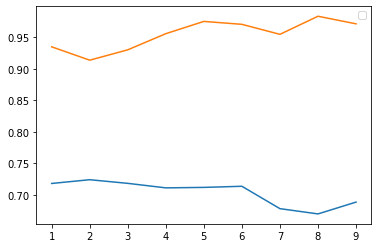

In [18]:
rvae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8, 9]
rvae = rVAE((28, 28), latent_dim=100, coord=1, seed=0)
trainer = SVItrainer(rvae)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_0.pkl')
score = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_01.pkl')
score = pair_matching(mnist_testset, [2, 3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012.pkl')
score = pair_matching(mnist_testset, [3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_0123.pkl')
score = pair_matching(mnist_testset, [4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_01234.pkl')
score = pair_matching(mnist_testset, [5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012345.pkl')
score = pair_matching(mnist_testset, [6, 7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_0123456.pkl')
score = pair_matching(mnist_testset, [7, 8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_01234567.pkl')
score = pair_matching(mnist_testset, [8, 9], rvae)
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_100_label_012345678.pkl')
score = pair_matching(mnist_testset, [9], rvae)
rvae_auc_scores.append(score)


vae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8, 9]
vae = rVAE((28, 28), latent_dim=100, coord=0, seed=0)
trainer = SVItrainer(vae)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_0.pkl')
score = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_01.pkl')
score = pair_matching(mnist_testset, [2, 3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_012.pkl')
score = pair_matching(mnist_testset, [3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_0123.pkl')
score = pair_matching(mnist_testset, [4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_01234.pkl')
score = pair_matching(mnist_testset, [5, 6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_012345.pkl')
score = pair_matching(mnist_testset, [6, 7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_0123456.pkl')
score = pair_matching(mnist_testset, [7, 8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_01234567.pkl')
score = pair_matching(mnist_testset, [8, 9], vae)
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_rotation_z_100_label_012345678.pkl')
score = pair_matching(mnist_testset, [9], vae)
vae_auc_scores.append(score)

plt.plot(num_classes_trained, vae_auc_scores)
plt.plot(num_classes_trained, rvae_auc_scores)
plt.legend()

### z = 10

In [ ]:
%%capture cap_f1
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_0.pkl', [0])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_01.pkl', [0, 1])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_012.pkl', [0, 1, 2])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_0123.pkl', [0, 1, 2, 3])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_01234.pkl', [0, 1, 2, 3, 4])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_rvae(mnist_trainset, 10, 'saved_models/rvae_rotation_z_10_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [59]:
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_0.pkl', [0])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_01.pkl', [0, 1])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_012.pkl', [0, 1, 2])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_0123.pkl', [0, 1, 2, 3])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_01234.pkl', [0, 1, 2, 3, 4])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_vae(mnist_trainset, 10, 'saved_models/vae_rotation_z_10_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUB

Text(0, 0.5, 'AUC score')

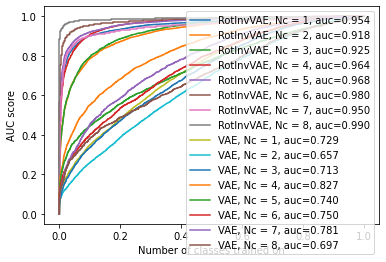

In [160]:
rvae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8]
rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_0.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 1, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_01.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [2, 3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 2, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_012.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [3, 4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 3, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_0123.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [4, 5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 4, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_01234.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5, 6, 7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 5, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_012345.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [6, 7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 6, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_0123456.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [7, 8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 7, auc="+"%.3f" % auc)

trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_01234567.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [8, 9], rvae)
rvae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="RotInvVAE, Nc = 8, auc="+"%.3f" % auc)

# trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_012345678.pkl')
# auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [9], rvae)
# rvae_auc_scores.append(auc)
# plt.plot(fpr,tpr,label="RotInvVAE, auc="+"%.3f" % auc)


vae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8]
vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_0.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 1, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_01.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [2, 3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 2, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_012.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [3, 4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 3, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_0123.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [4, 5, 6, 7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 4, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_01234.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5, 6, 7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 5, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_012345.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [6, 7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 6, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_0123456.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [7, 8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 7, auc="+"%.3f" % auc)

trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_01234567.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [8, 9], vae)
vae_auc_scores.append(auc)
plt.plot(fpr,tpr,label="VAE, Nc = 8, auc="+"%.3f" % auc)

# trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_012345678.pkl')
# auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [9], vae)
# rvae_auc_scores.append(auc)
# plt.plot(fpr,tpr,label="VAE, auc="+"%.3f" % auc)

# plt.bar(num_classes_trained, vae_auc_scores)
# plt.bar(num_classes_trained, rvae_auc_scores)
plt.legend()
plt.xlabel('Number of classes trained on')
plt.ylabel('AUC score')

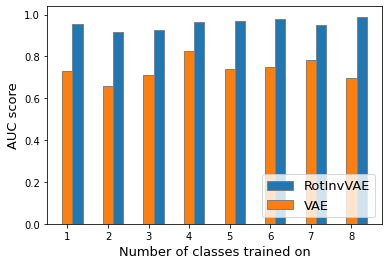

In [161]:
# set width of bar
barWidth = 0.25
# fig = plt.subplots(figsize =(6, 5))
 
# set height of bar
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+0.01, round(y[i], 2), ha = 'center')
 
# Set position of bar on X axis
br1 = np.arange(1, 9)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br2, rvae_auc_scores, width = barWidth,
        edgecolor ='grey', label ='RotInvVAE')
plt.bar(br1, vae_auc_scores, width = barWidth,
        edgecolor ='grey', label ='VAE')
# addlabels(br1, vae_auc_scores)
# addlabels(br2, rvae_auc_scores) 
# Adding Xticks
plt.xlabel('Number of classes trained on', fontsize = 13)
plt.ylabel('AUC score', fontsize = 13)
plt.legend(loc='lower right', fontsize=13)
plt.savefig("plots/scores_mnist.svg", bbox_inches='tight')
plt.show()

In [141]:
np.arange(1, 8)

array([1, 2, 3, 4, 5, 6, 7])

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


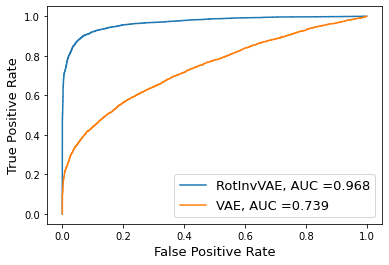

In [116]:
rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_01234.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5, 6, 7, 8, 9], rvae)
plt.plot(fpr,tpr,label="RotInvVAE, AUC ="+"%.3f" % auc)


vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_01234.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5, 6, 7, 8, 9], vae)
plt.plot(fpr,tpr,label="VAE, AUC ="+"%.3f" % auc,)

plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.savefig("plots/roc_curve_mnist.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

## fashionMNIST

In [37]:
fashionmnist_trainset = datasets.FashionMNIST('data/FashionMNIST/', train=True, download=True)
fashionmnist_testset = datasets.FashionMNIST('data/FashionMNIST/', train=False, download=True)

### z =100


In [ ]:
%%capture cap_f1
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_0.pkl', [0])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_01.pkl', [0, 1])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_012.pkl', [0, 1, 2])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_0123.pkl', [0, 1, 2, 3])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_01234.pkl', [0, 1, 2, 3, 4])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_rvae(fashionmnist_trainset, 100, 'saved_models/rvae_fashionmnist_rotation_z_100_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
%%capture cap_f1
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_0.pkl', [0])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_01.pkl', [0, 1])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_012.pkl', [0, 1, 2])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_0123.pkl', [0, 1, 2, 3])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_01234.pkl', [0, 1, 2, 3, 4])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_vae(fashionmnist_trainset, 100, 'saved_models/vae_fashionmnist_rotation_z_100_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### z =10

In [ ]:
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0.pkl', [0])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_01.pkl', [0, 1])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012.pkl', [0, 1, 2])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0123.pkl', [0, 1, 2, 3])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_01234.pkl', [0, 1, 2, 3, 4])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_rvae(fashionmnist_trainset, 10, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_0.pkl', [0])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_01.pkl', [0, 1])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_012.pkl', [0, 1, 2])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_0123.pkl', [0, 1, 2, 3])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_01234.pkl', [0, 1, 2, 3, 4])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345.pkl', [0, 1, 2, 3, 4, 5])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_0123456.pkl', [0, 1, 2, 3, 4, 5, 6])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_01234567.pkl', [0, 1, 2, 3, 4, 5, 6, 7])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345678.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8])
# train_vae(fashionmnist_trainset, 10, 'saved_models/vae_fashionmnist_rotation_z_10_label_0123456789.pkl', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUB

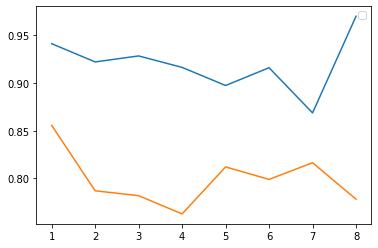

In [152]:
rvae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8]

rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0.pkl')
score = pair_matching(fashionmnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_01.pkl')
score = pair_matching(fashionmnist_testset, [2, 3, 4, 5, 6, 7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012.pkl')
score = pair_matching(fashionmnist_testset, [3, 4, 5, 6, 7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0123.pkl')
score = pair_matching(fashionmnist_testset, [4, 5, 6, 7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_01234.pkl')
score = pair_matching(fashionmnist_testset, [5, 6, 7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345.pkl')
score = pair_matching(fashionmnist_testset, [6, 7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_0123456.pkl')
score = pair_matching(fashionmnist_testset, [7, 8, 9], rvae)[0]
rvae_auc_scores.append(score)

trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_01234567.pkl')
score = pair_matching(fashionmnist_testset, [8, 9], rvae)[0]
rvae_auc_scores.append(score)

# trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345678.pkl')
# score = pair_matching(fashionmnist_testset, [9], rvae)[0]
# rvae_auc_scores.append(score)



vae_auc_scores = []
num_classes_trained = [1, 2, 3, 4, 5, 6, 7, 8]
vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_0.pkl')
score = pair_matching(fashionmnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_01.pkl')
score = pair_matching(fashionmnist_testset, [2, 3, 4, 5, 6, 7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_012.pkl')
score = pair_matching(fashionmnist_testset, [3, 4, 5, 6, 7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_0123.pkl')
score = pair_matching(fashionmnist_testset, [4, 5, 6, 7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_01234.pkl')
score = pair_matching(fashionmnist_testset, [5, 6, 7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345.pkl')
score = pair_matching(fashionmnist_testset, [6, 7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_0123456.pkl')
score = pair_matching(fashionmnist_testset, [7, 8, 9], vae)[0]
vae_auc_scores.append(score)

trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_01234567.pkl')
score = pair_matching(fashionmnist_testset, [8, 9], vae)[0]
vae_auc_scores.append(score)

# trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345678.pkl')
# score = pair_matching(fashionmnist_testset, [9], rvae)[0]
# vae_auc_scores.append(score)


plt.plot(num_classes_trained, rvae_auc_scores)
plt.plot(num_classes_trained, vae_auc_scores)
plt.legend()

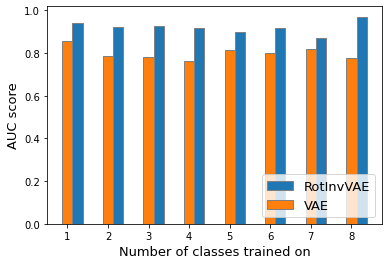

In [158]:
# set width of bar
barWidth = 0.25
# fig = plt.subplots(figsize =(6.4, 4.8))
 
# set height of bar
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+0.01, round(y[i], 2), ha = 'center')
 
# Set position of bar on X axis
br1 = np.arange(1, 9)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br2, rvae_auc_scores, width = barWidth,
        edgecolor ='grey', label ='RotInvVAE')
plt.bar(br1, vae_auc_scores, width = barWidth,
        edgecolor ='grey', label ='VAE')
# addlabels(br1, vae_auc_scores)
# addlabels(br2, rvae_auc_scores) 
# Adding Xticks
plt.xlabel('Number of classes trained on', fontsize = 13)
plt.ylabel('AUC score', fontsize = 13)
plt.legend(loc='lower right', fontsize=13)
plt.savefig("plots/scores_fashionmnist.svg", bbox_inches='tight')
plt.show()

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


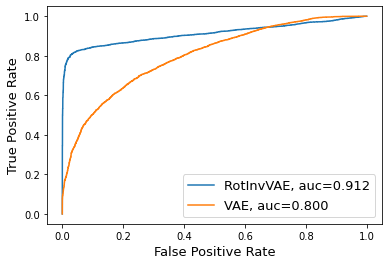

In [115]:
rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345.pkl')
auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [6, 7, 8, 9], rvae)
plt.plot(fpr,tpr,label="RotInvVAE, auc="+"%.3f" % auc)


vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345.pkl')
auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [6, 7, 8, 9], vae)
plt.plot(fpr,tpr,label="VAE, auc="+"%.3f" % auc)

plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.savefig("plots/roc_curve_fashionmnist.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

## train on MNIST test on FashionMNIST

In [50]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

In [52]:
fashionmnist_trainset = datasets.FashionMNIST('data/FashionMNIST/', train=True, download=True)
fashionmnist_testset = datasets.FashionMNIST('data/FashionMNIST/', train=False, download=True)

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUB

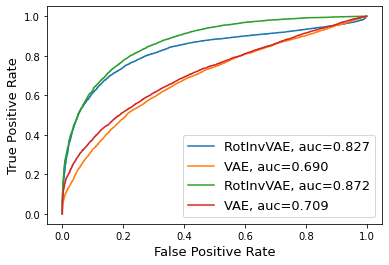

In [155]:
rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_rotation_z_10_label_012345678.pkl')
auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)
plt.plot(fpr,tpr,label="RotInvVAE, auc="+"%.3f" % auc)


vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_rotation_z_10_label_012345678.pkl')
auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], vae)
plt.plot(fpr,tpr,label="VAE, auc="+"%.3f" % auc)


rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345678.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)
plt.plot(fpr,tpr,label="RotInvVAE, auc="+"%.3f" % auc)


vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345678.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], vae)
plt.plot(fpr,tpr,label="VAE, auc="+"%.3f" % auc)

# plt.legend(loc='lower right', fontsize=13)
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=13)
# plt.savefig("plots/roc_curve_train_fashionmnist_test_mnist.svg", bbox_inches='tight')
# # plt.savefig('plots/roc_curve.png')
# plt.show()


plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.savefig("plots/roc_curve_mnist_fashionmnist.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


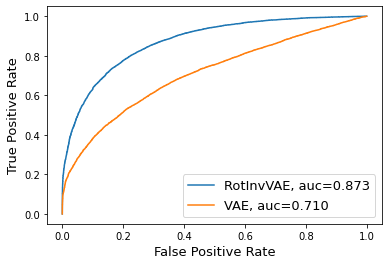

In [118]:
rvae = rVAE((28, 28), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_10_label_012345678.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], rvae)
plt.plot(fpr,tpr,label="RotInvVAE, auc="+"%.3f" % auc)


vae = rVAE((28, 28), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_10_label_012345678.pkl')
auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [1, 2, 3, 4, 5, 6, 7, 8, 9], vae)
plt.plot(fpr,tpr,label="VAE, auc="+"%.3f" % auc)

plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.savefig("plots/roc_curve_train_fashionmnist_test_mnist.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

## ORL dataset

In [11]:
import os
from tensorflow.keras.preprocessing.image import img_to_array , load_img

2023-01-30 19:44:10.155429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 19:44:10.325130: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-30 19:44:11.279660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib:/state/partition1/llgrid/pkg/

In [12]:
def get_orl_dataset(data_dir):
#     data_dir = 'data/ORL'
    NUM_DATA = len(os.listdir(data_dir))
    NUM_CATEGORY = int(len(os.listdir(data_dir))/10)

    def data_by_classe(imgs,NUM_CATEGORY):
        image = list()
        labels = list()
        for i in range(NUM_CATEGORY):
            num = i +1 
            for img in imgs :
                if int(img.split("_")[1].replace(".jpg" , ""))==num :
                    image.append(img)
                    labels.append(num)
        return image, labels
    
    data = list()
    images = os.listdir(data_dir)
    images, labels = data_by_classe(images , NUM_CATEGORY)
    for i, img in enumerate(images) :
        img = load_img(os.path.join(data_dir , img), target_size=(80, 70), color_mode="grayscale")
#         img = img_to_array(img)
        lbl = labels[i]
        if img is  not None :
            data.append((img, lbl))
    return data

In [13]:
orl_dataset = get_orl_dataset('data/ORL')

In [14]:
orl_traindata = get_mnist_data(orl_dataset, digits = list(np.arange(1, 22)), n_samples = None, rotation_range=[-60, 61], rotate = True)
orl_testdata = get_mnist_data(orl_dataset, digits = list(np.arange(22, 42)), n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21276094.0.0/ipykernel_14249/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


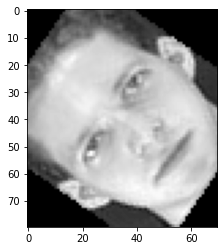

In [15]:
plt.imshow(orl_traindata[0][0], cmap = 'gray')

In [25]:
# %%capture cap_f1
rvae = rVAE((80, 70), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
train_rvae(orl_dataset, 10, 'saved_models/rvae_orl_rotation_z_10_label_half.pkl', list(np.arange(1, 22)), in_dim=(80, 70), batch_size=10)
trainer.load_model(rvae, 'saved_models/rvae_orl_rotation_z_10_label_half.pkl')

In [21]:
%%capture cap_f1
vae = rVAE((80, 70), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
train_vae(orl_dataset, 10, 'saved_models/vae_orl_rotation_z_10_label_half.pkl', list(np.arange(1, 22)), in_dim=(80, 70), batch_size=10)
trainer.load_model(vae, 'saved_models/vae_orl_rotation_z_10_label_half.pkl')

/state/partition1/slurm_tmp/21276094.0.0/ipykernel_14249/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21276094.0.0/ipykernel_14249/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


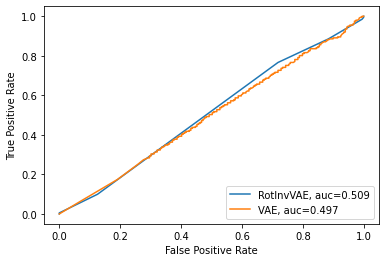

In [23]:
rvae = rVAE((80, 70), latent_dim=10, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_orl_rotation_z_10_label_half.pkl')
auc, fpr, tpr, thresholds = pair_matching(orl_dataset, list(np.arange(22, 42)), rvae)
plt.plot(fpr,tpr,label="RotInvVAE, auc="+"%.3f" % auc)


vae = rVAE((80, 70), latent_dim=10, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_orl_rotation_z_10_label_half.pkl')
auc, fpr, tpr, thresholds = pair_matching(orl_dataset, list(np.arange(22, 42)), vae)
plt.plot(fpr,tpr,label="VAE, auc="+"%.3f" % auc)

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("plots/roc_curve_mnist.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

## LFW dataset

In [17]:
# from sklearn.datasets import fetch_lfw_people
# import pickle
# # lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4, color=False , download_if_missing=True)
# lfw_people = fetch_lfw_people(resize=1, color=False , download_if_missing=True)
# output = open('lfw_data.pkl', 'wb')
# pickle.dump(lfw_people, output)
# output.close()

In [18]:
import pickle
pkl_file = open('data/lfw_data.pkl', 'rb')
lfw = pickle.load(pkl_file)
pkl_file.close()

target_names = lfw.target_names
n_classes = target_names.shape[0]
print('n_samples', lfw.images.shape[0])
print('n_classes', n_classes)

n_samples 13233
n_classes 5749


In [19]:
# from collections import defaultdict
# import copy
# import random
# def get_test_labels():
#     freq = defaultdict(int)
#     y_copy = copy.deepcopy(lfw.target)
#     random.shuffle(y_copy)
#     for i in y_copy:
#         freq[i] += 1
#     ctr = 0
#     l = []
#     for i in freq.keys():
#         l.append(i)
#         ctr += freq[i]
#         if(ctr > len(lfw.target) / 10):
#             break
#     print(ctr, l)
#     return l

# test_targets = get_test_labels()
# train_targets = list(set(lfw.target) - set(test_targets))

# output = open('data/lfw_test_targets.pkl', 'wb')
# pickle.dump(test_targets, output)
# output.close()

# output = open('data/lfw_train_targets.pkl', 'wb')
# pickle.dump(train_targets, output)
# output.close()

# pkl_file = open('data/lfw_test_targets.pkl', 'rb')
# test_targets = pickle.load(pkl_file)
# pkl_file.close()

# pkl_file = open('data/lfw_train_targets.pkl', 'rb')
# train_targets = pickle.load(pkl_file)
# pkl_file.close()

In [20]:
import pickle
def get_orl_dataset(data_dir):
    pkl_file = open(data_dir, 'rb')
    lfw = pickle.load(pkl_file)
    pkl_file.close()
    
    target_names = lfw.target_names
    n_classes = target_names.shape[0]
    print('n_classes', n_classes)
    
    data = []
    images, labels = lfw.images, lfw.target
    for i, img in enumerate(images):
        h, w = img.shape
        final_len = int(np.sqrt((h/2)**2 + (w/2)**2)) + 1
        pad_h = final_len - int(h/2)
        pad_w = final_len - int(w/2)
        img = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), 'constant', constant_values=(0))
        img = Image.fromarray(img/255)
        img = img.resize([50, 50])
        data.append((img, labels[i]))
    
    return data

In [21]:
lfw_dataset = get_orl_dataset('data/lfw_data.pkl')

n_classes 5749


In [22]:
lfw_traindata = get_mnist_data(lfw_dataset, digits = [2], n_samples = None, rotation_range=[-60, 61], rotate = True)

/state/partition1/slurm_tmp/21337581.0.0/ipykernel_79624/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


torch.Size([50, 50])


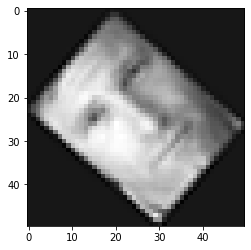

In [23]:
print(lfw_traindata[0][0].shape)
plt.imshow(lfw_traindata[0][0], cmap = 'gray')

In [47]:
%%capture cap_f1
import pickle

n_classes = 5749
in_dim=[50, 50]

pkl_file = open('data/lfw_test_targets.pkl', 'rb')
test_targets = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('data/lfw_train_targets.pkl', 'rb')
train_targets = pickle.load(pkl_file)
pkl_file.close()

# saved_models/rvae_lfw_rotation_z_100.pkl is trained on hidden_dim=256, epochs =100
# train_rvae(lfw_dataset, 10, 'saved_models/rvae_lfw_rotation_z_10.pkl', train_targets, in_dim, epochs=100, hidden_dim_e=128, hidden_dim_d=128)
rvae = rVAE(in_dim, latent_dim=10, coord=1, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_lfw_rotation_z_10.pkl')

In [48]:
%%capture cap_f1
n_classes = 5749
in_dim=[50, 50]

pkl_file = open('data/lfw_test_targets.pkl', 'rb')
test_targets = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('data/lfw_train_targets.pkl', 'rb')
train_targets = pickle.load(pkl_file)
pkl_file.close()

# train_vae(lfw_dataset, 10, 'saved_models/vae_lfw_rotation_z_10.pkl', train_targets, in_dim, epochs=100, hidden_dim_e=128, hidden_dim_d=128)
vae = rVAE(in_dim, latent_dim=10, coord=0, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_lfw_rotation_z_10.pkl')

/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21312444.0.0/ipykernel_76363/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


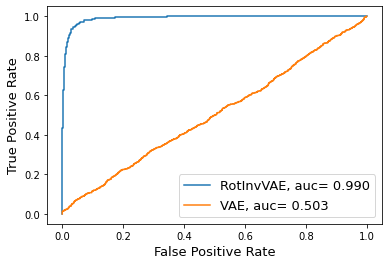

In [119]:
n_classes = 5749
in_dim=[50, 50]
pkl_file = open('data/lfw_test_targets.pkl', 'rb')
test_targets = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('data/lfw_train_targets.pkl', 'rb')
train_targets = pickle.load(pkl_file)
pkl_file.close()

# train_rvae(lfw_dataset, 100, 'saved_models/rvae_lfw_rotation_z_100.pkl', train_targets, in_dim, epochs=300)
rvae = rVAE(in_dim, latent_dim=10, coord=1, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_lfw_rotation_z_10.pkl')
auc, fpr, tpr, thresholds = pair_matching(lfw_dataset, test_targets, rvae)
plt.plot(fpr,tpr, label="RotInvVAE, auc= %.3f" % auc)
plt.legend(loc=4)

# train_vae(lfw_dataset, 100, 'saved_models/vae_lfw_rotation_z_100.pkl', train_targets, in_dim, epochs=300)
vae = rVAE(in_dim, latent_dim=10, coord=0, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_lfw_rotation_z_10.pkl')
auc, fpr, tpr, thresholds = pair_matching(lfw_dataset, test_targets, vae)
plt.plot(fpr,tpr, label="VAE, auc= %.3f" % auc)
plt.legend(loc=4)

plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.savefig("plots/roc_curve_lfw.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

/state/partition1/slurm_tmp/21337581.0.0/ipykernel_79624/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)
/state/partition1/slurm_tmp/21337581.0.0/ipykernel_79624/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


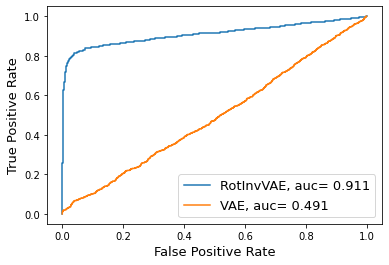

In [27]:
n_classes = 5749
in_dim=[50, 50]
pkl_file = open('data/lfw_test_targets.pkl', 'rb')
test_targets = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('data/lfw_train_targets.pkl', 'rb')
train_targets = pickle.load(pkl_file)
pkl_file.close()

# train_rvae(lfw_dataset, 100, 'saved_models/rvae_lfw_rotation_z_100.pkl', train_targets, in_dim, epochs=300)
rvae = rVAE(in_dim, latent_dim=10, coord=1, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_lfw_rotation_z_10.pkl')
auc, fpr, tpr, thresholds = class_matching(lfw_dataset, test_targets, rvae)
plt.plot(fpr,tpr, label="RotInvVAE, auc= %.3f" % auc)
plt.legend(loc=4)

# train_vae(lfw_dataset, 100, 'saved_models/vae_lfw_rotation_z_100.pkl', train_targets, in_dim, epochs=300)
vae = rVAE(in_dim, latent_dim=10, coord=0, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_lfw_rotation_z_10.pkl')
auc, fpr, tpr, thresholds = class_matching(lfw_dataset, test_targets, vae)
plt.plot(fpr,tpr, label="VAE, auc= %.3f" % auc)
plt.legend(loc=4)

plt.legend(loc='lower right', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.savefig("plots/roc_curve_lfw.svg", bbox_inches='tight')
# plt.savefig('plots/roc_curve.png')
plt.show()

### visualisations

In [33]:
%%capture cap_f1
pkl_file = open('data/lfw_test_targets.pkl', 'rb')
test_targets = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('data/lfw_train_targets.pkl', 'rb')
train_targets = pickle.load(pkl_file)
pkl_file.close()

train_data, train_labels, train_angles = get_mnist_data(lfw_dataset, train_targets, n_samples = None, rotation_range=[-60, 61], rotate = True)

train_rvae(lfw_dataset, 2, 'saved_models/rvae_lfw_rotation_z_2.pkl', train_targets, in_dim, epochs=100, hidden_dim_e=128, hidden_dim_d=128)
rvae = rVAE(in_dim, latent_dim=2, coord=1, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_lfw_rotation_z_2.pkl')

In [34]:
pkl_file = open('data/lfw_test_targets.pkl', 'rb')
test_targets = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('data/lfw_train_targets.pkl', 'rb')
train_targets = pickle.load(pkl_file)
pkl_file.close()

train_data, train_labels, train_angles = get_mnist_data(lfw_dataset, train_targets, n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21337581.0.0/ipykernel_79624/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


In [30]:
rvae = rVAE(in_dim, latent_dim=10, coord=1, seed=0, hidden_dim_e=128, hidden_dim_d=128)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_lfw_rotation_z_10.pkl')

z = rvae.encode(train_data)
x_decoded = rvae.decode(z)

In [31]:
# rvae.manifold2d(d=12, cmap='viridis')

/state/partition1/slurm_tmp/21337581.0.0/ipykernel_79624/3484953940.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(5, 2))


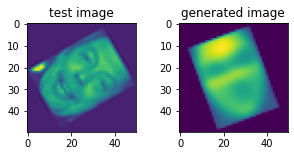

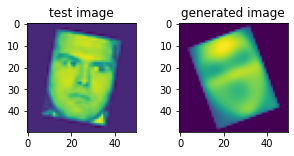

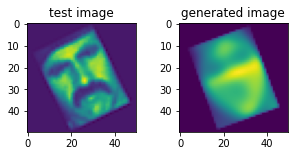

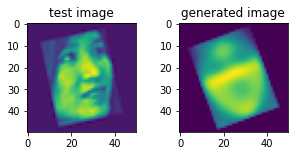

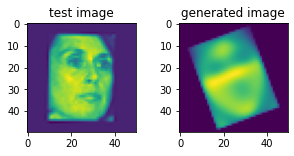

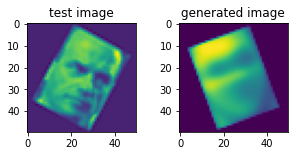

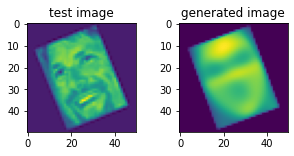

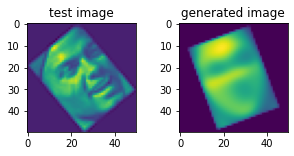

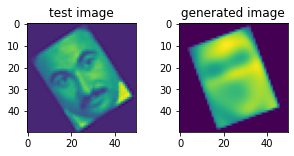

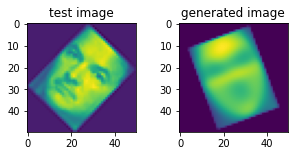

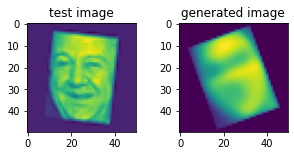

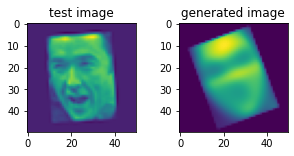

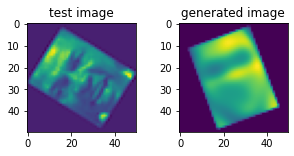

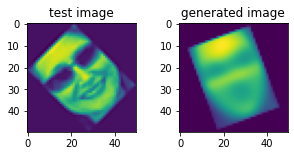

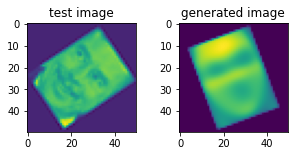

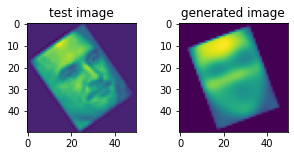

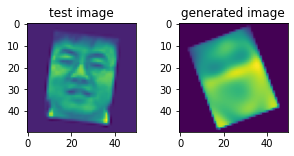

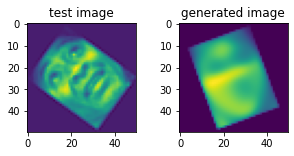

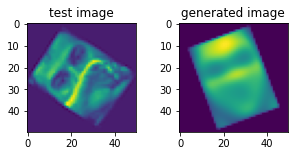

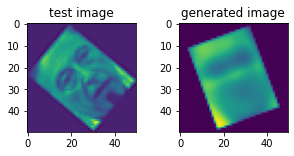

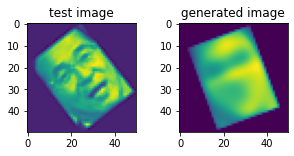

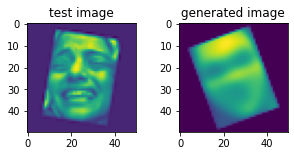

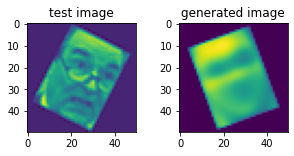

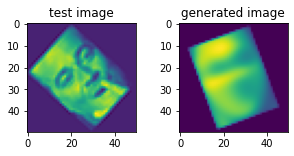

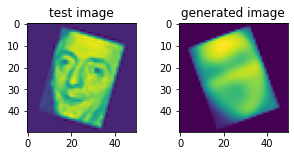

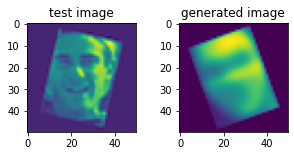

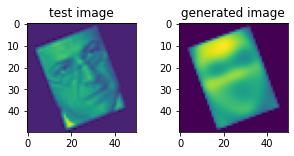

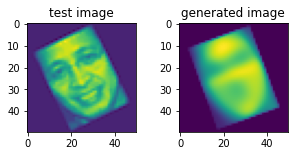

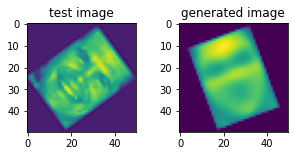

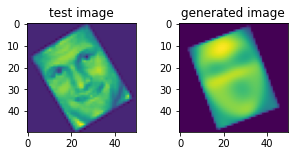

In [32]:
for i in range(30):
    # plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(5, 2))
    ax1.imshow(train_data[i].view(50, 50).cpu().detach().numpy())
    ax1.set_title('test image')
    ax2.imshow(x_decoded[i].view(50, 50).cpu().detach().numpy())
    ax2.set_title('generated image')
    # plt.imshow(test_data[i].view(28, 28).cpu().detach().numpy())
    # plt.figure()
    # plt.imshow(x_decoded[i].view(28, 28).cpu().detach().numpy())

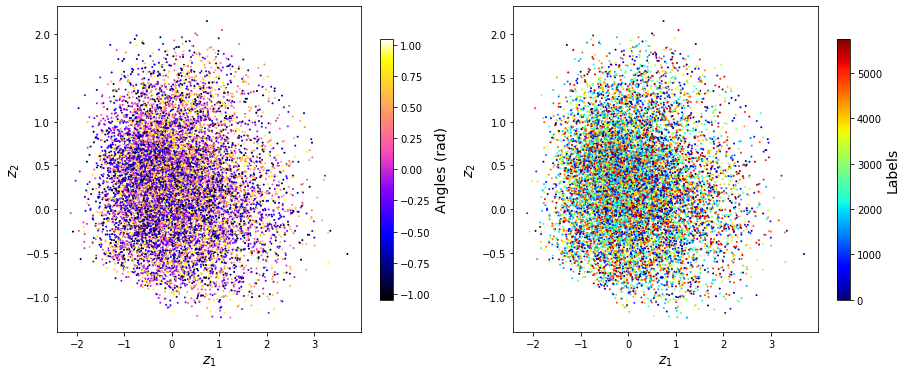

In [35]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
# plt.savefig("plots/rvae_train_visualisations_fashion.png")

In [36]:
# train_targets = list(set(np.arange(0, n_classes)) - set([373, 2507, 3351, 3351, 5458]))
test_targets = list(set([373, 2507, 2941, 3351, 3351, 5458, 5569]))
test_data, test_labels, test_angles = get_mnist_data(lfw_dataset, test_targets, n_samples = None, rotation_range=[-60, 61], rotate = True)
# orl_testdata = get_mnist_data(orl_dataset, digits = list(np.arange(22, 42)), n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21337581.0.0/ipykernel_79624/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


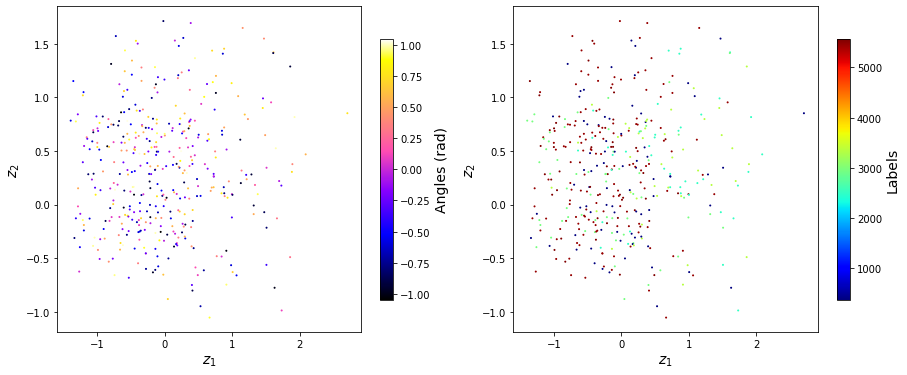

In [37]:
z_mean, z_sd = rvae.encode(test_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=test_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=test_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/rvae_test_visualisations_fashion.png")

# Visualisations

## MNIST

In [14]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = [0], n_samples = None, rotation_range=[-60, 61], rotate = True)
train_loader = init_dataloader(train_data, batch_size=200)

/state/partition1/slurm_tmp/21287596.0.0/ipykernel_89175/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


### rvae

In [134]:
%%capture cap_f1
# train_rvae(mnist_trainset, 2, 'saved_models/rvae_rotation_z_2_label_01234.pkl', [0, 1, 2, 3, 4])
rvae = rVAE((28, 28), latent_dim=2, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_rotation_z_2_label_01234.pkl')
train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = [0, 1, 2, 3, 4], n_samples = None, rotation_range=[-60, 61], rotate = True)
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


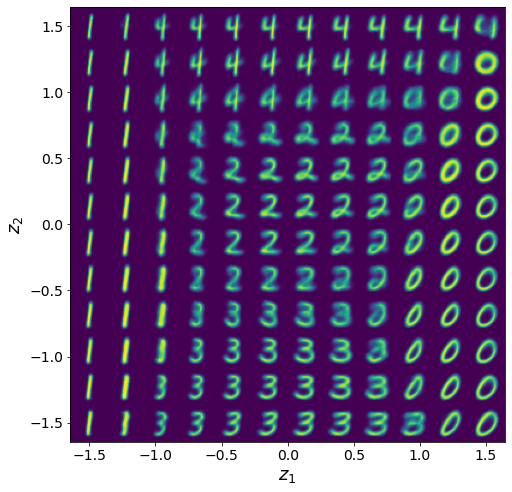

In [135]:
rvae.manifold2d(d=12, cmap='viridis')

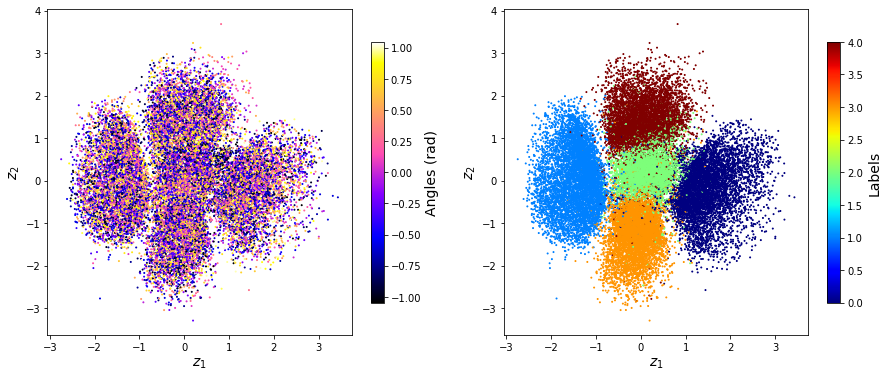

In [136]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
# plt.savefig("plots/rvae_train_visualisations.svg", bbox_inches='tight')
plt.savefig("plots/rvae_train_visualisations.png")

In [26]:
test_data, test_labels, test_angles = get_mnist_data(mnist_trainset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21269346.0.0/ipykernel_43041/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


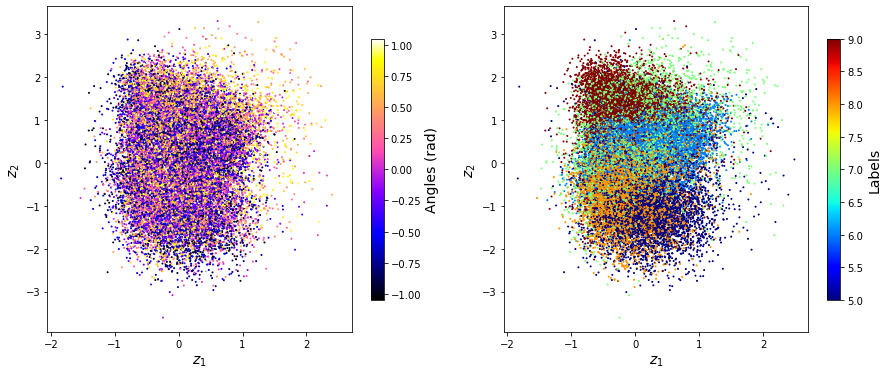

In [33]:
z_mean, z_sd = rvae.encode(test_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=test_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=test_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/rvae_test_visualisations.svg", bbox_inches='tight')
plt.savefig("plots/rvae_test_visualisations.png")

### vae

In [34]:
%%capture cap_f1
# train_vae(mnist_trainset, 2, 'saved_models/vae_rotation_z_2_label_01234.pkl', [0, 1, 2, 3, 4])
vae = rVAE((28, 28), latent_dim=2, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_rotation_z_2_label_01234.pkl')
test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


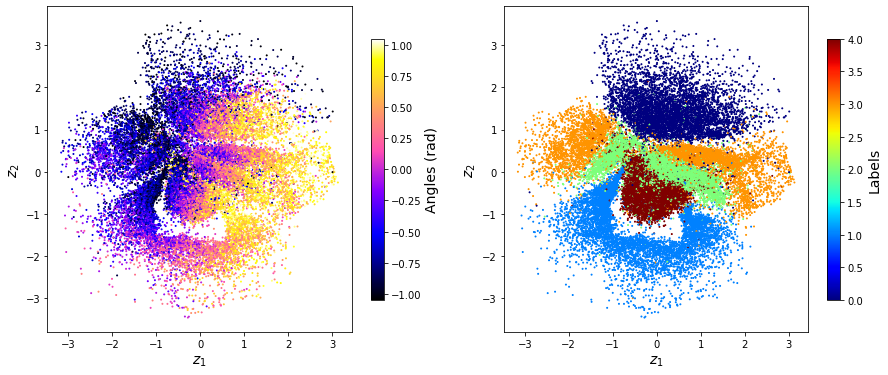

In [35]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/vae_train_visualisations.svg", bbox_inches='tight')
plt.savefig("plots/vae_train_visualisations.png")

In [36]:
test_data, test_labels, test_angles = get_mnist_data(mnist_trainset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21269346.0.0/ipykernel_43041/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


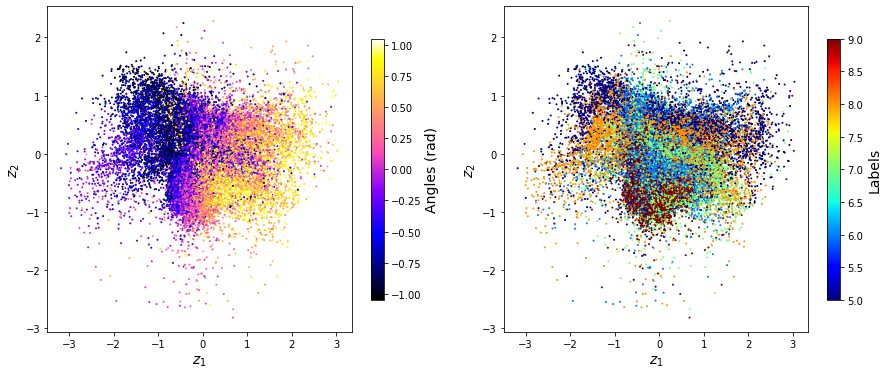

In [37]:
z_mean, z_sd = vae.encode(test_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=test_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=test_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/vae_test_visualisations.svg", bbox_inches='tight')
plt.savefig("plots/vae_test_visualisations.png")

## FashionMNIST

In [137]:
fashionmnist_trainset = datasets.FashionMNIST('data/FashionMNIST/', train=True, download=True)
fashionmnist_testset = datasets.FashionMNIST('data/FashionMNIST/', train=False, download=True)

### rvae

In [138]:
%%capture cap_f1
# train_rvae(fashionmnist_trainset, 2, 'saved_models/rvae_fashionmnist_rotation_z_2_label_01234.pkl', [0, 1, 2, 3, 4])
rvae = rVAE((28, 28), latent_dim=2, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_fashionmnist_rotation_z_2_label_01234.pkl')
train_data, train_labels, train_angles = get_mnist_data(fashionmnist_trainset, digits = [0, 1, 2, 3, 4], n_samples = None, rotation_range=[-60, 61], rotate = True)
test_data, test_labels, test_angles = get_mnist_data(fashionmnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


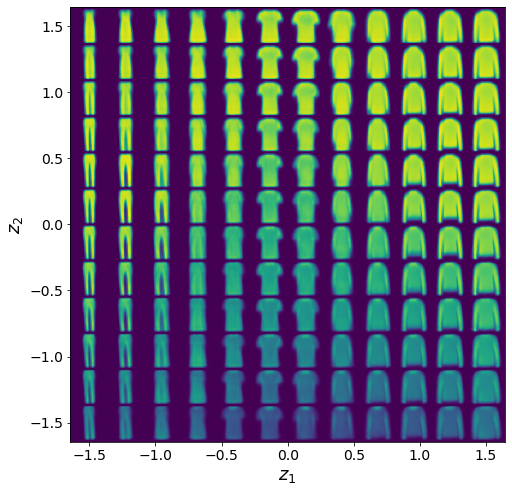

In [139]:
rvae.manifold2d(d=12, cmap='viridis')

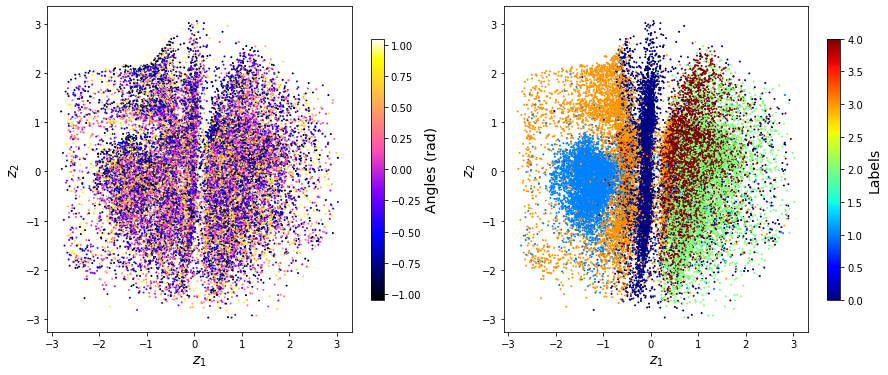

In [140]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/rvae_train_visualisations_fashion.png")

In [141]:
test_data, test_labels, test_angles = get_mnist_data(fashionmnist_trainset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21276094.0.0/ipykernel_14249/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


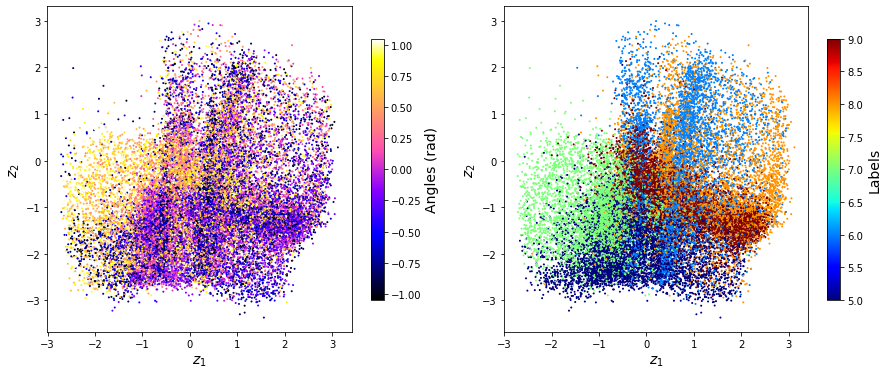

In [142]:
z_mean, z_sd = rvae.encode(test_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=test_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=test_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/rvae_test_visualisations_fashion.png")

### vae

In [143]:
%%capture cap_f1
# train_vae(fashionmnist_trainset, 2, 'saved_models/vae_fashionmnist_rotation_z_2_label_01234.pkl', [0, 1, 2, 3, 4])
vae = rVAE((28, 28), latent_dim=2, coord=0, seed=0)
trainer = SVItrainer(vae)
trainer.load_model(vae, 'saved_models/vae_fashionmnist_rotation_z_2_label_01234.pkl')
train_data, train_labels, train_angles = get_mnist_data(fashionmnist_trainset, digits = [0, 1, 2, 3, 4], n_samples = None, rotation_range=[-60, 61], rotate = True)
test_data, test_labels, test_angles = get_mnist_data(fashionmnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


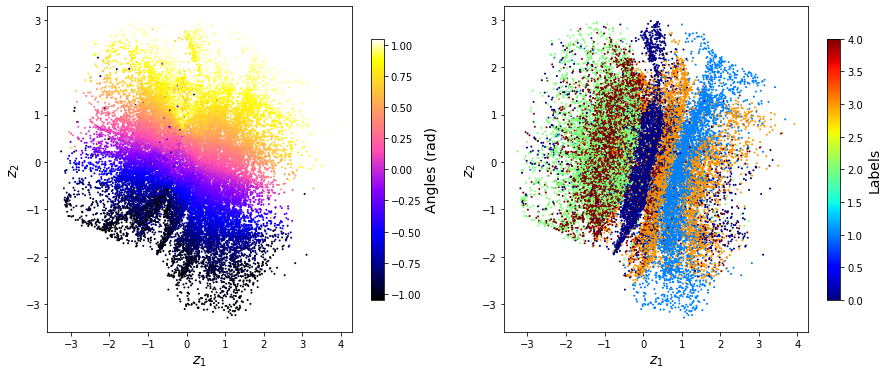

In [144]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/vae_train_visualisations_fashion.png")

In [145]:
test_data, test_labels, test_angles = get_mnist_data(fashionmnist_trainset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21276094.0.0/ipykernel_14249/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


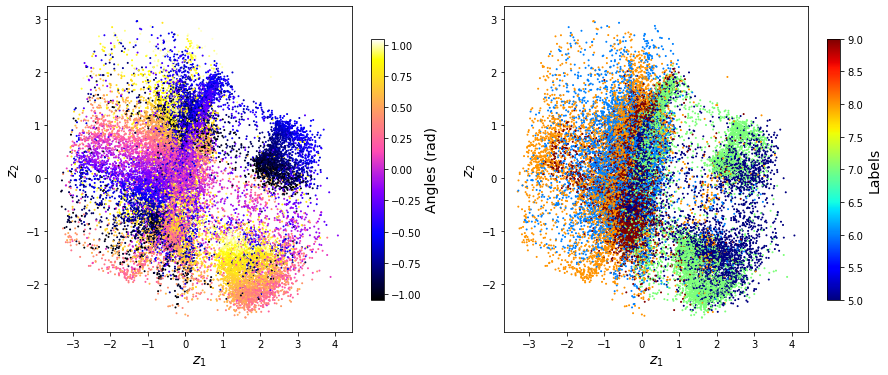

In [146]:
z_mean, z_sd = vae.encode(test_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=test_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=test_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);
plt.savefig("plots/vae_test_visualisations_fashion.png")

## ORL dataset

In [24]:
orl_dataset = get_orl_dataset('data/ORL')

In [31]:
train_data, train_labels, train_angles = get_mnist_data(orl_dataset, digits = list(np.arange(1, 22)), n_samples = None, rotation_range=[-60, 61], rotate = True)
test_data, test_labels, test_angles = get_mnist_data(orl_dataset, digits = list(np.arange(22, 42)), n_samples = None, rotation_range=[-60, 61], rotate = True)


/state/partition1/slurm_tmp/21276094.0.0/ipykernel_14249/3643694743.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  im = im.rotate(theta.item(), resample=Image.BICUBIC)


In [32]:
%%capture cap_f1
# train_rvae(orl_dataset, 2, 'saved_models/rvae_orl_rotation_z_2_label_half.pkl', list(np.arange(1, 22)), in_dim=(80, 70))
rvae = rVAE((80, 70), latent_dim=2, coord=1, seed=0)
trainer = SVItrainer(rvae)
trainer.load_model(rvae, 'saved_models/rvae_orl_rotation_z_2_label_half.pkl')
# train_data, train_labels, train_angles = get_mnist_data(mnist_trainset, digits = [0, 1, 2, 3, 4], n_samples = None, rotation_range=[-60, 61], rotate = True)
# test_data, test_labels, test_angles = get_mnist_data(mnist_testset, digits = [5,6,7,8,9], n_samples = None, rotation_range=[-60, 61], rotate = True)


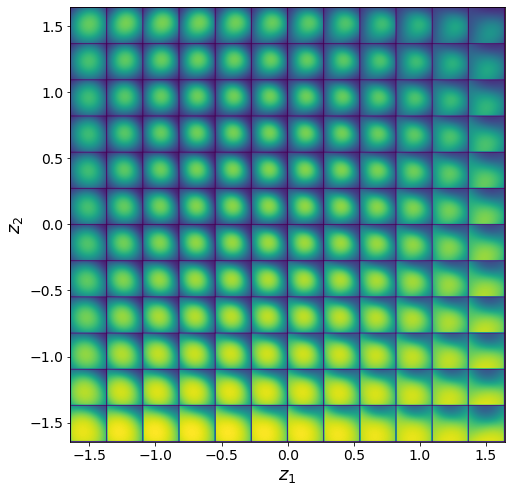

In [33]:
rvae.manifold2d(d=12, cmap='viridis')

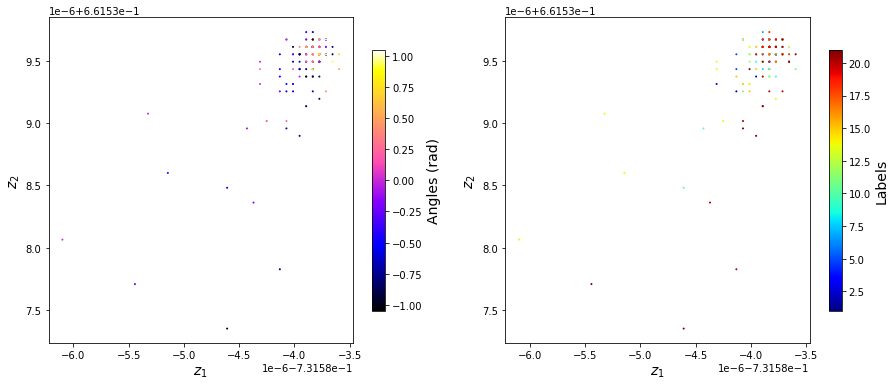

In [34]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=train_angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);